In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import jax
import jax.numpy as jnp
from envs.KS_environment_jax import KSenv
from envs.KS_solver_jax import KS
import ml_collections
from functools import partial
import matplotlib.pyplot as plt

In [2]:
def get_low_initial_condition(u0, model_N, env_N, model_k):
    # fourier transform the initial condition
    u0_f = jnp.fft.rfft(u0, axis=-1)
    # get lower order
    # make sure the magnitude of fourier modes match
    u0_f_low = model_N / env_N * u0_f[: len(model_k)]
    u0_low = jnp.fft.irfft(u0_f_low)
    return u0_low

def get_observation_matrix(model_N, model_L, x):
    # get the matrix to do inverse fft on observation points
    k = model_N * jnp.fft.fftfreq(model_N) * 2 * jnp.pi / model_L
    k_x = jnp.einsum("i,j->ij", x, k) * 1j
    exp_k_x = jnp.exp(k_x)
    M = 1 / model_N * exp_k_x
    return M

def generate_episode(env, episode_type='null_action'):
    # create a action of zeros to pass
    null_action = jnp.zeros(env.action_size)

    env_step = partial(
        KSenv.step,
        frame_skip=env.frame_skip,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        target=env.target,
        actuator_loss_weight=env.actuator_loss_weight,
        termination_threshold=env.termination_threshold,
        observation_inds=env.observation_inds,
    )
    env_step = jax.jit(env_step)
    env_sample_action = partial(
        KSenv.sample_continuous_space,
        low=env.action_low,
        high=env.action_high,
        shape=(env.action_size,),
    )
    env_sample_action = jax.jit(env_sample_action)

    def null_action_episode(true_state, episode_steps):
        def forecast_fun(carry, _):
            true_state = carry

            # get action
            action = null_action

            # get the next observation and reward with this action
            true_state, _, _, _, _, _ = env_step(
                state=true_state, action=action
            )

            return true_state, (
                true_state,
                action,
            )
        true_state, (true_state_arr,action_arr)= jax.lax.scan(forecast_fun, true_state, jnp.arange(episode_steps))
        return (true_state_arr,action_arr)
    def random_action_episode(true_state,episode_steps,key_action):
        def forecast_fun(carry, _):
            true_state, key_action = carry

            # get action
            key_action, _ = jax.random.split(key_action)
            action = env_sample_action(key=key_action)

            # get the next observation and reward with this action
            true_state, _, _, _, _, _ = env_step(state=true_state, action=action)

            return (true_state, key_action), (true_state, action)
        (true_state, key_action), (true_state_arr,action_arr) = jax.lax.scan(forecast_fun,(true_state, key_action),jnp.arange(episode_steps))
        return (true_state_arr,action_arr)
    if episode_type == 'null_action':
        return null_action_episode
    elif episode_type == 'random_action':
        return random_action_episode

In [3]:
# configuration
config = ml_collections.ConfigDict()
config.env = ml_collections.ConfigDict()
N_high = 64
config.env.N = N_high
config.env.nu = 0.08
config.env.actuator_scale = 0.1
config.env.actuator_loss_weight = 0.2
config.env.burn_in = 1000
config.env.actuator_locs =  ((2 * jnp.pi) / 8) * jnp.arange(8)
config.env.sensor_locs = ((2 * jnp.pi) / N_high) * jnp.arange(N_high)
config.env.target = "e0"
config.env.frame_skip = 1
episode_steps = 5000

In [4]:
# create envi<ronment
env = KSenv(**config.env)
x = env.ks_solver.x

seed = 0
key = jax.random.PRNGKey(seed)
key, key_env, key_obs, key_action = jax.random.split(key, 4) 

env_reset = partial(
    KSenv.reset,
    N=env.N,
    B=env.ks_solver.B,
    lin=env.ks_solver.lin,
    ik=env.ks_solver.ik,
    dt=env.ks_solver.dt,
    initial_amplitude=env.initial_amplitude,
    action_size=env.action_size,
    burn_in=env.burn_in,
    observation_inds=env.observation_inds,
)

env_reset = jax.jit(env_reset)
u0,_,_ = env_reset(key=key_env)

episode_type = 'random_action'
episode = generate_episode(env, episode_type=episode_type)

true_state_arr, action_arr = episode(true_state=u0,episode_steps=episode_steps, key_action=key_action)

# get fourier coefficients
true_state_arr_f = jnp.fft.rfft(true_state_arr, axis=1)
mag_state_arr = 2 / env.N * jnp.abs(true_state_arr_f)

In [5]:
N_list = [32, 20, 16, 14]
true_state_arr_list = [true_state_arr]
mag_state_arr_list = [mag_state_arr]
err_list = [jnp.abs(true_state_arr.T-true_state_arr.T)]
for N in N_list:
    # initialize 
    config.env.N = N
    config.env.sensor_locs = ((2 * jnp.pi) / N) * jnp.arange(N)
    env1 = KSenv(**config.env)

    # generate episode with the new number of Fourier modes
    episode = generate_episode(env1, episode_type=episode_type)
    u0_low = get_low_initial_condition(u0, model_N=env1.N, env_N=env.N, model_k=env1.ks_solver.k)
    true_state_arr1, action_arr1 = episode(true_state=u0_low,episode_steps=episode_steps, key_action=key_action)

    # get the state in full resolution
    full_obs_mat = get_observation_matrix(env1.N, env1.ks_solver.L, x)
    true_state_arr_f1 = jnp.fft.fft(true_state_arr1, axis=1)
    full_true_state_arr1 = jnp.real((full_obs_mat @ true_state_arr_f1.T).T)

    # get fourier coefficients
    mag_state_arr1 = 2 / env1.N * jnp.abs(true_state_arr_f1)

    # append
    true_state_arr_list.append(full_true_state_arr1)
    mag_state_arr_list.append(mag_state_arr1)
    err_list.append(jnp.abs(true_state_arr.T-full_true_state_arr1.T))
N_list = [N_high] + N_list

In [6]:
plt.style.use("stylesheet.mplstyle")

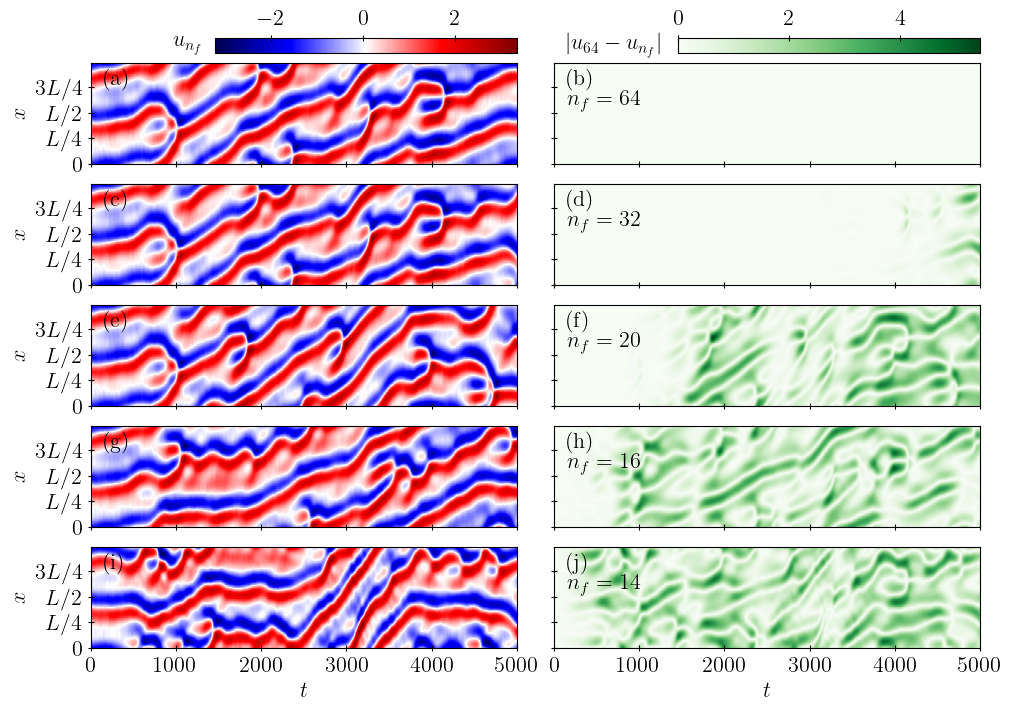

In [7]:
# initialize figure
fig = plt.figure(layout="constrained", figsize=(10,7))
# subfigs = fig.subfigures(1, 1,)
axs = fig.subplots(
    len(N_list),
    2,
)
# plot_dim = 4
# axs1 = subfigs[1].subplots(plot_dim, 1)
u_max = jnp.max(jnp.vstack(true_state_arr_list))
u_min = jnp.min(jnp.vstack(true_state_arr_list))
err_max = jnp.max(jnp.vstack(err_list))
err_min = jnp.min(jnp.vstack(err_list))
titles = list(map(chr, range(ord('a'), ord('z')+1)))
k = 0
for i, N in enumerate(N_list):
    im = axs[i, 0].imshow(true_state_arr_list[i].T, aspect='auto',
              extent=[0, len(true_state_arr), x[0], x[-1]],
              origin="lower",
              cmap="seismic",
              vmax=u_max,
              vmin=u_min)
    if i == 0:
        cbar = fig.colorbar(im, ax=[axs[0, 0]], location="top", anchor=(1.0,0.5), pad=0.1)
        # cbar.ax.set_ylabel(f"$u_{{n_f = {N}}}$", rotation=90, labelpad=15, va="center")
        cbar.ax.set_ylabel("$u_{n_f}$", rotation=0, labelpad=20, va="center")
    # axs[i, 0].set_title(f"$u_{{n_f = {N}}}$")
    axs[i, 0].annotate(f"({titles[k]})", xy=(0.03, 0.78), xycoords="axes fraction")
    k += 1
    im = axs[i, 1].imshow(err_list[i], aspect='auto',
              extent=[0, len(true_state_arr), x[0], x[-1]],
              origin="lower",
              cmap="Greens",
              vmax=err_max,
              vmin=err_min)
    if i == 0:
        cbar = fig.colorbar(im, ax=[axs[0, 1]], location="top", anchor=(1.0,0.5), pad=0.1)
        # cbar.ax.set_ylabel(f"$|u_{{64}}-u_{{{N}}}|$", rotation=90, labelpad=15, va="center")
        cbar.ax.set_ylabel("$|u_{{64}}-u_{n_f}|$", rotation=0, labelpad=45, va="center")
    # axs[i, 1].set_title(f"$|u_{{64}}-u_{{{N}}}|$")
    # Labels
    axs[i, 1].annotate(f"({titles[k]})", xy=(0.03, 0.78), xycoords="axes fraction")
    axs[i, 1].annotate(f"$n_f = {{{N}}}$", xy=(0.03, 0.58), xycoords="axes fraction")
    k += 1
    x_plt = [0, env.ks_solver.L/4, env.ks_solver.L/2, 3*env.ks_solver.L/4]
    x_plt_str = ["$0$", "$L/4$", "$L/2$", "$3L/4$",]
    axs[i, 0].set_yticks(x_plt)
    axs[i, 0].set_yticklabels(x_plt_str)
    # axs[i, 0].set_yticklabels([])
    axs[i, 0].set_ylabel("$x$")

    axs[i, 1].set_yticks(x_plt)
    axs[i, 1].set_yticklabels([])
    
    if i < (len(N_list) - 1):
        axs[i, 0].set_xticklabels([])
        axs[i, 1].set_xticklabels([])
    else:
        axs[i, 0].set_xlabel("$t$")
        axs[i, 1].set_xlabel("$t$")
# fig.savefig('fig_mb_fo_prediction.pdf', bbox_inches="tight")
fig.savefig('fig_mb_fo_prediction.png', bbox_inches="tight")
# for i, ax in enumerate(axs1):
#     ax.plot(mag_state_arr[:,1+i])
#     for j, N in enumerate(N_list):
#         ax.plot(mag_state_arr1_list[j][:,1+i])